# Depth Validation

validating the use of depth information in rgb-d and rgb-hha models

In [1]:
import sys
sys.path.insert(0,'src')

In [2]:
import time
import itertools

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import cv2

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub

from src import utils, eval_utils#, rgbd_model, rgb_model, depth_model, hha_model, rgb_hha_model

## Load dataset(s)

In [3]:
train_data_path = 'C:/Users/awnya/Documents/Projects/RGBD Object Classification/RGBD_dataset' + '/train'
test_data_path = 'C:/Users/awnya/Documents/Projects/RGBD Object Classification/RGBD_dataset' + '/test'

In [4]:
#
start_time = time.time()

print('loading rgbd test dataset')
# rgbd_train_dataset = utils.create_rgbd_dataset(train_data_path, azure=False)
rgbd_test_dataset = utils.create_rgbd_dataset(test_data_path, azure=False)

print(f'done! took {time.time()-start_time:.2f} seconds')

loading rgbd test dataset
done! took 28.28 seconds


In [5]:
#
start_time = time.time()

print('loading rgb-hha test dataset')
# rgbd_train_dataset = utils.create_rgbd_dataset(train_data_path, azure=False)
rgb_hha_test_dataset = utils.create_rgb_hha_dataset(test_data_path, azure=False)

print(f'done! took {time.time()-start_time:.2f} seconds')

loading rgb-hha test dataset
done! took 15.07 seconds


## Load model(s)

In [6]:
import rgb_hha_model, rgbd_model

In [7]:
rgb_feat_vec_embedding = hub.KerasLayer('models/bit_m-r50x1_1')

In [8]:
hha_weights_path = 'src/models_archive/hha_run2_epoch6_weights.h5'

hha_feat_extractor = rgb_hha_model.build_hha_feature_extractor(
    weights=hha_weights_path, trainable=True)
# hha_feat_extractor.summary()

# now build rgb-hha model
rgb_hha_mdl = rgb_hha_model.build_rgb_hha_model(input_shape=(200, 200), num_classes=51,
    hha_feat_vec_embedding=hha_feat_extractor, rgb_feat_vec_embedding=rgb_feat_vec_embedding,
    model_name='rgb-hha_model')

In [9]:
rgbd_mdl = rgbd_model.build_model(input_shape=(200, 200), num_classes=51, 
    feat_vec_embedding=rgb_feat_vec_embedding)

In [10]:
rgbd_weights = 'src/models_archive/rgbd_model_run29_epoch3_weights.h5'
rgbd_mdl.load_weights(rgbd_weights)

## Examine Trained weights

### rgb-hha

In [11]:
dense1_weights = rgb_hha_mdl.get_layer(name='dense1').weights[0]
dense1_weights

<tf.Variable 'dense1/kernel:0' shape=(2624, 128) dtype=float32, numpy=
array([[ 0.00485337,  0.0370518 ,  0.03148115, ..., -0.01139698,
        -0.0157712 ,  0.00720362],
       [ 0.02729065, -0.02300362,  0.03460974, ...,  0.04548569,
         0.04217534,  0.01311868],
       [ 0.00383689, -0.0386081 , -0.04589466, ..., -0.034739  ,
         0.01073905, -0.03964961],
       ...,
       [ 0.02321245, -0.01699773,  0.00683903, ..., -0.02642203,
         0.04015265, -0.01984203],
       [ 0.0028841 ,  0.02406581, -0.04326599, ...,  0.02971659,
        -0.02902151,  0.03877369],
       [ 0.04032741,  0.02111966,  0.01489621, ..., -0.01736065,
         0.002801  , -0.04421365]], dtype=float32)>

In [12]:
rgb_weights = dense1_weights[:2048]
hha_weights = dense1_weights[-576:]

In [13]:
for name, weights in [('rgb', rgb_weights), ('hha', hha_weights)]:
    print(f"\n\n{'-'*30}\n{name}:")

    print(f'avg: {np.average(np.abs(weights))}')
    print(f'median: {np.median(np.abs(weights))}')
    print(f'max: {np.max(weights)}')
    print(f'min: {np.min(weights)}')
    print(f'std: {np.std(weights)}')



------------------------------
rgb:
avg: 0.02335641346871853
median: 0.02339925616979599
max: 0.04669244587421417
min: -0.04669293761253357
std: 0.026961617171764374


------------------------------
hha:
avg: 0.023459911346435547
median: 0.02350500598549843
max: 0.04669198393821716
min: -0.04669151455163956
std: 0.027063513174653053


results: all statistics almost identical...

### rgb-d

In [14]:
dense1_weights = rgbd_mdl.get_layer(name='dense1').weights[0]
dense1_weights

<tf.Variable 'dense1/kernel:0' shape=(2624, 128) dtype=float32, numpy=
array([[ 0.01389671, -0.00398814,  0.00222813, ..., -0.01448179,
         0.14257964, -0.0127115 ],
       [-0.00167028, -0.12044226, -0.03236815, ..., -0.01964624,
         0.02263955,  0.0066269 ],
       [-0.10899132, -0.09754838, -0.02063757, ..., -0.04244673,
         0.00974357, -0.03693372],
       ...,
       [-0.02111984, -0.00108565,  0.02134815, ..., -0.03997415,
         0.03468368, -0.02181706],
       [ 0.03983618, -0.01885728, -0.04094834, ...,  0.01095223,
        -0.00877238, -0.01518761],
       [-0.00902191, -0.00205019,  0.0148508 , ...,  0.03920665,
         0.01647745, -0.04122907]], dtype=float32)>

In [15]:
rgb_weights = dense1_weights[:2048]
depth_weights = dense1_weights[-576:]

In [16]:
for name, weights in [('rgb', rgb_weights), ('depth', depth_weights)]:
    print(f"\n\n{'-'*30}\n{name}:")

    print(f'avg absolute: {np.average(np.abs(weights))}')
    print(f'median: {np.median(np.abs(weights))}')
    print(f'max: {np.max(weights)}')
    print(f'min: {np.min(weights)}')
    print(f'std: {np.std(weights)}')



------------------------------
rgb:
avg absolute: 0.04485052451491356
median: 0.029391683638095856
max: 0.8412381410598755
min: -0.9375953078269958
std: 0.0712394043803215


------------------------------
depth:
avg absolute: 0.024327704682946205
median: 0.02351420745253563
max: 0.16914620995521545
min: -0.16942475736141205
std: 0.028688514605164528


this time, statistics not identical. but they are similar (same order of magnitude). avg and median absolute values higher on rgb, and max/min significantly higher. std lower on depth.

## Saliency Maps

side note: class activation maps didn't work due to a graph disconnection issue...

In [17]:
import eval_utils

In [18]:
(x_rgb, x_hha), y = rgb_hha_test_dataset.batch(1).__iter__().next()

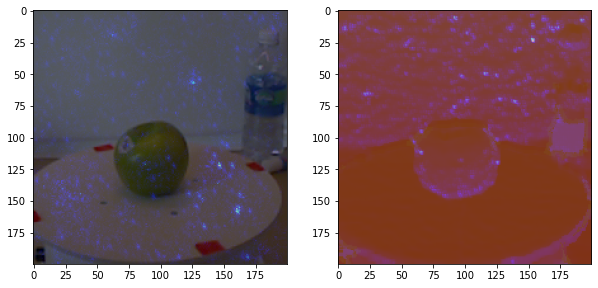

In [19]:
eval_utils.gen_saliency_map([x_rgb, x_hha], y, rgb_hha_mdl);